In [1]:
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb
from skimage import data
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage import morphology
from skimage.color import label2rgb
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches

ImportError: libSM.so.6: cannot open shared object file: No such file or directory

In [253]:
# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

net.eval()


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

In [254]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())


In [255]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam



In [256]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')


In [257]:
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()


In [258]:
logit.shape

torch.Size([1, 1000])

In [259]:
classes

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [260]:
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))


0.678 -> mountain bike, all-terrain bike, off-roader
0.088 -> bicycle-built-for-two, tandem bicycle, tandem
0.042 -> unicycle, monocycle
0.038 -> horse cart, horse-cart
0.019 -> lakeside, lakeshore


In [261]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])


# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)


output CAM.jpg for the top1 prediction: mountain bike, all-terrain bike, off-roader


True

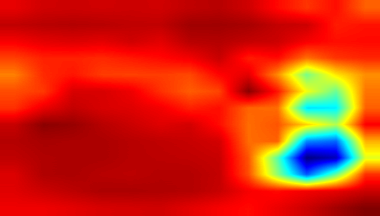

In [262]:
Image.fromarray(heatmap)

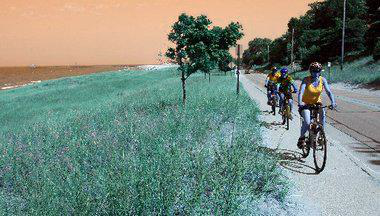

In [263]:
Image.fromarray(img)

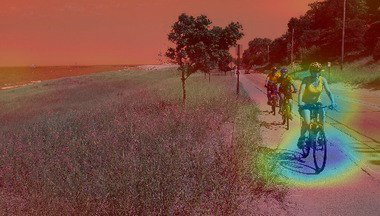

In [264]:
Image.fromarray(result.astype('uint8'))

In [265]:

CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0], idx[1], idx[2], idx[3], idx[4]])
results = []
heatmaps = []
for i in range(5):
    # render the CAM and output
    print('output CAM{}.jpg for the top{} prediction: {}'.format(i, i, classes[idx[i]]))
    img = cv2.imread('test.jpg')
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[i],(width, height)), cv2.COLORMAP_JET)
    heatmaps.append(heatmap)
    result = heatmap * 0.3 + img * 0.5
    results.append(result)
    cv2.imwrite('CAM_{}.jpg'.format(i), result)


output CAM0.jpg for the top0 prediction: mountain bike, all-terrain bike, off-roader
output CAM1.jpg for the top1 prediction: bicycle-built-for-two, tandem bicycle, tandem
output CAM2.jpg for the top2 prediction: unicycle, monocycle
output CAM3.jpg for the top3 prediction: horse cart, horse-cart
output CAM4.jpg for the top4 prediction: lakeside, lakeshore


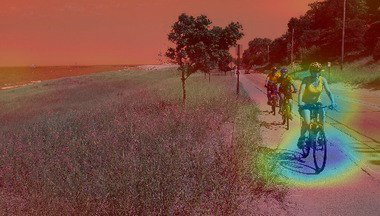

In [266]:
Image.fromarray(results[0].astype('uint8'))

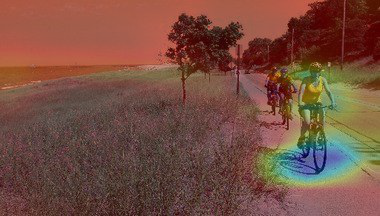

In [267]:
Image.fromarray(results[1].astype('uint8'))

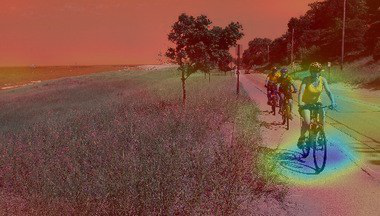

In [268]:
Image.fromarray(results[2].astype('uint8'))

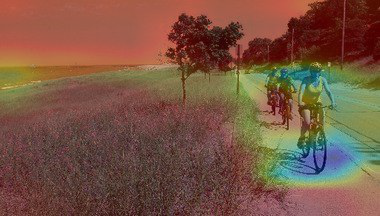

In [269]:
Image.fromarray(results[3].astype('uint8'))

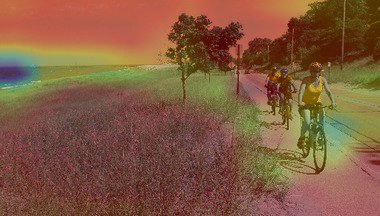

In [270]:
Image.fromarray(results[4].astype('uint8'))

In [271]:
# global_thresh = threshold_otsu(heatmap)
# binary_global = heatmap > 0.2*heatmap.max()
CAMs_scaled = [cv2.resize(c,(width, height)) for c in CAMs]
binary_globals = [h > 0.7 * h.max() for h in CAMs_scaled]
all_globals = sum(binary_globals)

In [272]:
label_image = label(all_globals>0, connectivity=2, background=0)
image_label_overlay = label2rgb(label_image, image=img)

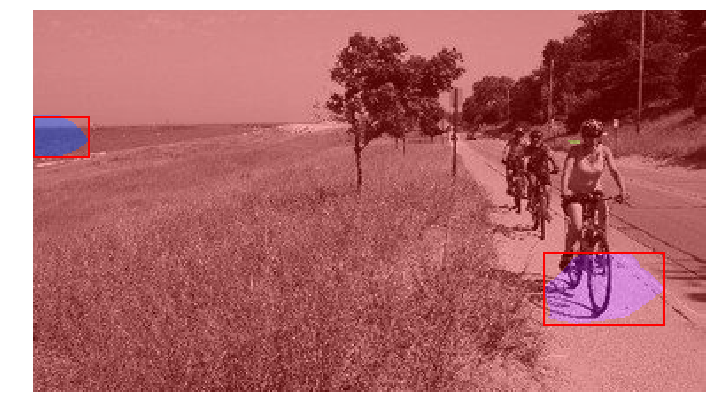

In [273]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

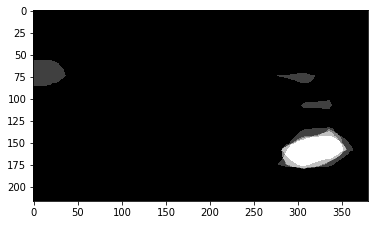

In [207]:
plt.imshow(all_globals)

In [191]:
np.unique(binary_globals[1])

array([False,  True])

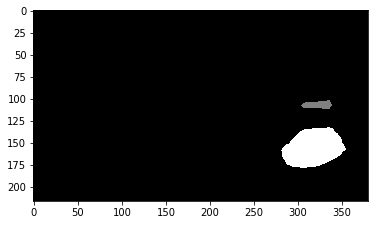

In [171]:
mask = morphology.label(binary_globals[0], connectivity=2, background=0)
plt.imshow(mask*255, cmap=plt.get_cmap('gray'))

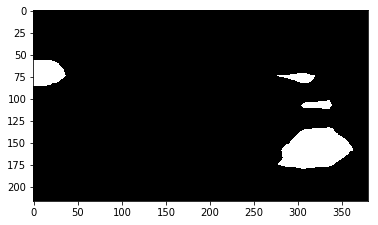

In [192]:
all_global = sum(binary_globals)
plt.imshow(sum(binary_globals)>0)

In [186]:
np.unique(all_global)

array([0, 1, 2, 3, 4])